Scrapimg data from the E-Books websites

In [2]:
!pip install --upgrade pip
!pip install --upgrade numpy   
!pip install --upgrade pandas
!pip install seaborn
!pip install requests
!pip install pandas
!python -m pip install beautifulsoup4



In [3]:
import sys
print(sys.version)

3.11.6 (tags/v3.11.6:8b6ee5b, Oct  2 2023, 14:57:12) [MSC v.1935 64 bit (AMD64)]


In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import requests
from urllib.request import urlopen
from bs4 import BeautifulSoup
import re

In [6]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import re

BASE_URL = "https://www.goodreads.com/list/show/62.Best_Feminist_Books?page="

headers = {
    "User-Agent": "Mozilla/5.0"
}

books = []

for page in range(1, 7):  # 6 pages ≈ 200 books
    url = BASE_URL + str(page)
   # print(f"Fetching page {page}...")

    resp = requests.get(url, headers=headers)
    soup = BeautifulSoup(resp.text, "html.parser")

    rows = soup.find_all("tr", {"itemtype": "http://schema.org/Book"})

    for r in rows:
        # Rank
        #rank = r.find("td", class_="number").get_text(strip=True)

        # Title
        title = r.find("a", class_="bookTitle").get_text(strip=True)

        # Author
        author = r.find("a", class_="authorName").get_text(strip=True)

        # Rating info (contains avg rating + ratings count)
        rating_text = r.find("span", class_="minirating").get_text(strip=True)

        # Extract avg rating
        avg_rating = re.search(r"(\d\.\d+)", rating_text)
        avg_rating = avg_rating.group(1) if avg_rating else None

        # Extract ratings count
        ratings_count = re.search(r"([\d,]+)\sratings", rating_text)
        ratings_count = ratings_count.group(1) if ratings_count else None

        # Score & Votes (List specific)
        score_block = r.find("span", class_="smallText uitext")
        score = None
        #votes = None

        if score_block:
            text = score_block.get_text(" ", strip=True)

            score_match = re.search(r"score:\s*([\d,]+)", text)
            votes_match = re.search(r"(\d+)\svotes", text)

            score = score_match.group(1) if score_match else None
            votes = votes_match.group(1) if votes_match else None

        books.append({
            "Title": title,
            "Author": author,
            "AverageRating": avg_rating,
            "RatingsCount": ratings_count,
            "Score": score,
        })

    time.sleep(1)

df = pd.DataFrame(books)
df.to_csv("feminist_books.csv", index=False)
print("Saved successfully!")

Saved successfully!


In [7]:
df.head()

,Title,Author,AverageRating,RatingsCount,Score
0,"The Handmaid’s Tale (The Handmaid's Tale, #1)",Margaret Atwood,4.15,"2,450,864","84,020"
1,The Bell Jar,Sylvia Plath,4.05,"1,238,927","49,948"
2,Jane Eyre,Charlotte Brontë,4.16,"2,340,543","45,133"
3,A Room of One’s Own,Virginia Woolf,4.22,"264,643","43,909"
4,The Second Sex,Simone de Beauvoir,4.18,"47,693","38,713"


In [9]:
#counting rows and columns
df.shape

(600, 5)

In [13]:
#checkig the Datatypes of the values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Title          600 non-null    object
 1   Author         600 non-null    object
 2   AverageRating  600 non-null    object
 3   RatingsCount   600 non-null    object
 4   Score          600 non-null    object
dtypes: object(5)
memory usage: 23.6+ KB


In [8]:
#converting the AverageRating column to numeric, coercing errors to NaN 
df["AverageRating"] = pd.to_numeric(df["AverageRating"], errors="coerce")
print(df["AverageRating"].dtype)
df['RatingsCount'] = (
    df['RatingsCount']
    .astype(str)                 # convert to string first
    .str.replace(',', '', regex=False)  # remove comma
)

df['RatingsCount'] = pd.to_numeric(df['RatingsCount'], errors='coerce')
df['RatingsCount'] = df['RatingsCount'].fillna(0).astype(int)
print(df["RatingsCount"].dtype)
df['Score'] = (
    df['Score']
    .astype(str)
    .str.replace(',', '')   # remove commas like 1,000
    .str.strip()
)
df['Score'] = pd.to_numeric(df['Score'], errors='coerce')
print(df['Score'].dtype)

float64
int64
int64


In [15]:
#checking  the datatypes of the values after the conversion of datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Title          600 non-null    object 
 1   Author         600 non-null    object 
 2   AverageRating  600 non-null    float64
 3   RatingsCount   600 non-null    int64  
 4   Score          600 non-null    int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 23.6+ KB


In [9]:
#checking unique values of title
df['Title'].nunique() # There is 598 unique title there

598

In [10]:
#len(data)
df['Title'].value_counts()

Title
Medea                                                                     2
Middlesex                                                                 2
The Handmaid’s Tale (The Handmaid's Tale, #1)                             1
The Bell Jar                                                              1
Jane Eyre                                                                 1
                                                                         ..
Two Serious Ladies                                                        1
Breakfast at Tiffany’s and Three Stories                                  1
Runaway: Stories                                                          1
Lust                                                                      1
The Frailty Myth: Redefining the Physical Potential of Women and Girls    1
Name: count, Length: 598, dtype: int64

In [11]:
#checking the duplicate titles
df[df.duplicated('Title')] #there is 2 duplicate title

,Title,Author,AverageRating,RatingsCount,Score
319,Middlesex,Jeffrey Eugenides,4.04,665286,559
448,Medea,Christa Wolf,3.92,5074,328


In [9]:
#Droping the Two duplicates rows from the dataset
df = df.drop_duplicates(subset='Title')
df.shape

(598, 5)

# Stastical Implementation

In [12]:
#Its Describe the Statiscal information the dataset
df.describe(include="all")

,Title,Author,AverageRating,RatingsCount,Score
count,600,600,600.000000,6.000000e+02,600.000000
unique,598,437,NaN,NaN,NaN
top,Medea,Margaret Atwood,NaN,NaN,NaN
freq,2,9,NaN,NaN,NaN
mean,NaN,NaN,4.039600,2.699456e+05,2402.500000
std,NaN,NaN,0.252116,9.058205e+05,6143.113999
min,NaN,NaN,2.880000,7.000000e+00,224.000000
25%,NaN,NaN,3.870000,2.496000e+03,326.750000
50%,NaN,NaN,4.040000,1.807050e+04,597.500000
75%,NaN,NaN,4.210000,1.409688e+05,1623.500000


In [13]:
#checkinh the null values
df.isnull()

,Title,Author,AverageRating,RatingsCount,Score
0,False,False,False,False,False
1,False,False,False,False,False
2,False,False,False,False,False
3,False,False,False,False,False
4,False,False,False,False,False
...,...,...,...,...,...
595,False,False,False,False,False
596,False,False,False,False,False
597,False,False,False,False,False
598,False,False,False,False,False


In [14]:
#hecking percentage of missing values
df.isnull().sum()

Title            0
Author           0
AverageRating    0
RatingsCount     0
Score            0
dtype: int64

# Exploratory Data Analysis

# Univariate Analysis

array([[<Axes: title={'center': 'AverageRating'}>,
        <Axes: title={'center': 'RatingsCount'}>],
       [<Axes: title={'center': 'Score'}>, <Axes: >]], dtype=object)

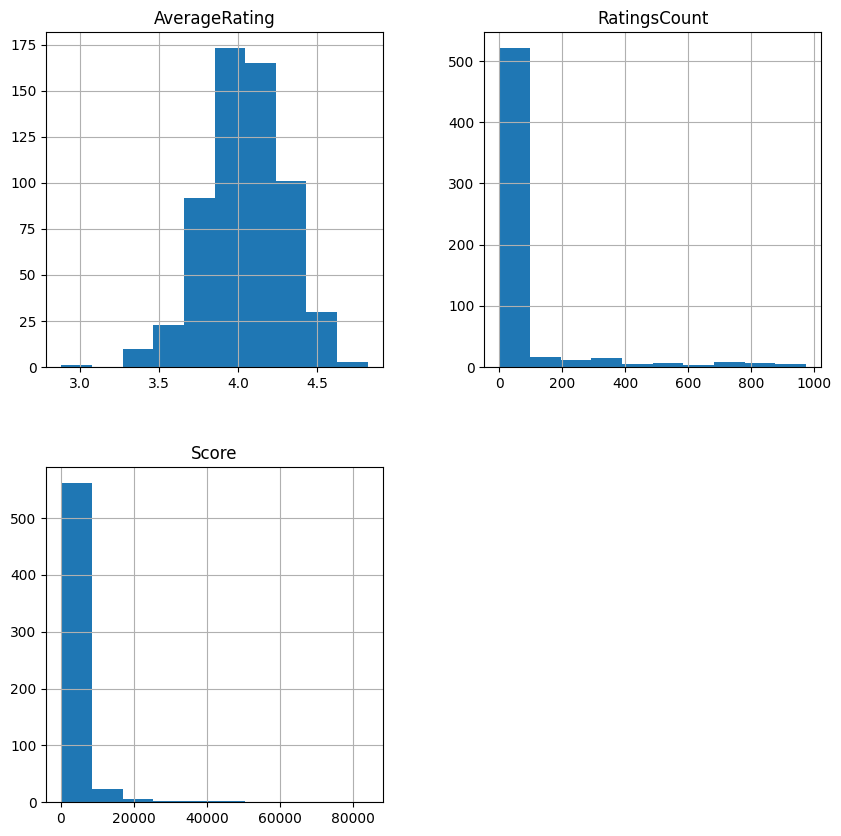

In [48]:
df.hist(figsize=(10, 10))

<Axes: >

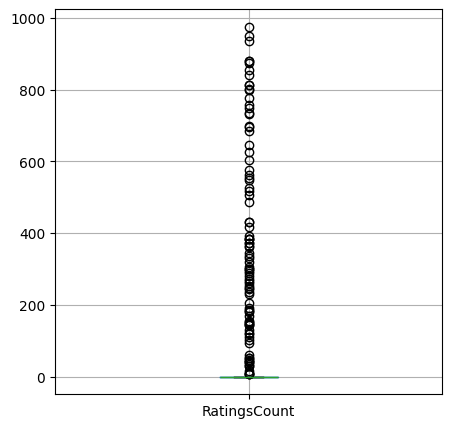

In [49]:
#df.boxplot(column=["AverageRating"],figsize=(5,5))
df.boxplot(column=["RatingsCount"],figsize=(5,5))
#df.boxplot(column=["Score"],figsize=(5,5))


## Bivariate Analysis

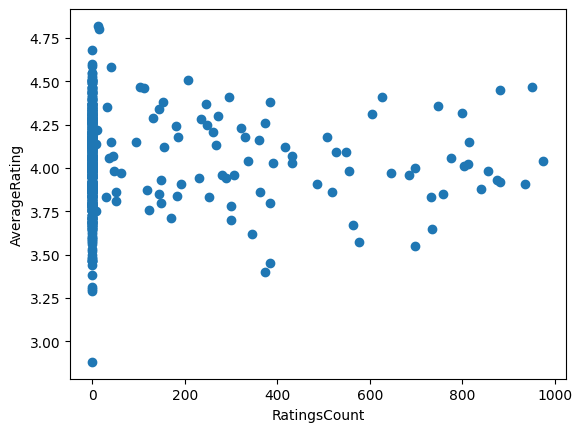

In [50]:
import matplotlib.pyplot as plt
plt.scatter(df["RatingsCount"], df["AverageRating"])
plt.xlabel("RatingsCount")
plt.ylabel("AverageRating")
plt.show()

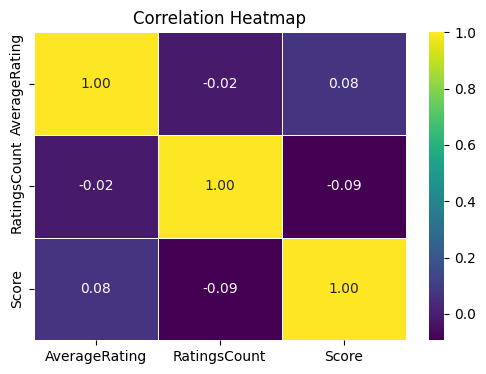

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
# Correlation matrix
corr = df[["AverageRating", "RatingsCount", "Score"]].corr()
# Plot heatmap
plt.figure(figsize=(6,4))
sns.heatmap(corr,
            annot=True,
            cmap="viridis",
            fmt=".2f",
            linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [15]:
!python -m pip install scipy

In [10]:
# Import required library
from scipy.stats import pearsonr

# Select variables
x = df["RatingsCount"]
y = df["Score"]

# Perform Pearson correlation test
correlation_coefficient, p_value = pearsonr(x, y)

# Print results clearly
print("===== Pearson Correlation Test =====")
print(f"Correlation Coefficient (r): {correlation_coefficient:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpretation
if p_value < 0.05:
    print("Result: Statistically significant relationship (Reject H0)")
else:
    print("Result: No statistically significant relationship (Fail to Reject H0)")

===== Pearson Correlation Test =====
Correlation Coefficient (r): 0.2334
P-value: 0.0000
Result: Statistically significant relationship (Reject H0)


In [ ]:
#H₀: There is no linear relationship between Log_RatingsCount and Log_Score (ρ = 0)
#H₁: There is a linear relationship between Log_RatingsCount and Log_Score (ρ ≠ 0)

Model Traning

In [16]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [11]:
#Import required libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

In [12]:
#  Select features (X) and target (y)
X = df[["RatingsCount", "AverageRating"]]  # Input features
y = df["Score"]  # Target variable

Standarad 

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

model = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(alpha=0.01))
])

In [14]:
print(y.describe())

count      598.000000
mean      2409.051839
std       6152.343481
min        224.000000
25%        324.250000
50%        600.000000
75%       1632.500000
max      84020.000000
Name: Score, dtype: float64


Linear Regression 

In [15]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)
# Predict on test data
y_pred = model.predict(X_test)
# Step 6: Evaluate model performance

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("Model Evaluation Results")
print("--------------------------")
print("R² Score:", round(r2, 4))
print("Mean Squared Error:", round(mse, 4))


Model Evaluation Results
--------------------------
R² Score: 0.0437
Mean Squared Error: 31800526.3798


# Random Forest Classifier

In [27]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest R2:", r2_score(y_test, y_pred_rf))

Random Forest R2: 0.073445324479962


# Decision Tree

In [17]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

dt = DecisionTreeRegressor(
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)

dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print("Decision Tree R2:", r2_score(y_test, y_pred_dt))

Decision Tree R2: -0.4198031016535537


# Ridge Regression

In [18]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
print("Ridge R2:", round(r2_score(y_test, y_pred_ridge), 4))

Ridge R2: 0.0445


# Lasso Regression

In [19]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
print("Lasso R2:", round(r2_score(y_test, y_pred_lasso), 4))

Lasso R2: 0.0437


Model Comparison


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
# Assuming X_train, X_test, y_train, y_test already prepared
# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}
results = []
# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    results.append({
        "Model": name,
        "R2 Score": r2,
        "MSE": mse
    })
    print(f"{name} --> R2: {r2:.4f}, MSE: {mse:.2f}")

Linear Regression --> R2: 0.0437, MSE: 31800526.38
Ridge --> R2: 0.0445, MSE: 31774086.64
Lasso --> R2: 0.0437, MSE: 31800453.85
Decision Tree --> R2: -2.6071, MSE: 119954521.86
Random Forest --> R2: 0.0760, MSE: 30728198.68


Mean Absolute Error

In [21]:
from sklearn.metrics import mean_absolute_error
# The LinearRegression model instance is stored in the 'model' variable from a previous cell.
# Assign it to 'lin_reg' to be consistent with the models dictionary names.
lin_reg = model
# Models dictionary
models = {
    "Linear Regression": lin_reg,
    "Ridge": ridge,
    "Lasso": lasso,
    "Decision Tree": dt,
    "Random Forest": rf
}
# Predict & calculate MAE
for name, model in models.items():
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{name} --> MAE: {round(mae, 2)}")

Linear Regression --> MAE: 2879.21
Ridge --> MAE: 2811.66
Lasso --> MAE: 2815.56
Decision Tree --> MAE: 3203.65
Random Forest --> MAE: 2836.88


Model Comparison

In [22]:
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
# Suppose predictions already irukku
# y_test = actual values
# Model predictions
y_pred_lr = y_pred     # Linear Regression predictions from cell naHw9MlxU7-Z
y_pred_ridge = y_pred_ridge
y_pred_lasso = y_pred_lasso
y_pred_dt = y_pred_dt # Decision Tree predictions from cell 3Qth6nNRhtVm
y_pred_rf = y_pred_rf
# Metrics store panna list
models = ['Linear Regression', 'Ridge', 'Lasso', 'Decision Tree', 'Random Forest']
r2_scores = [
    r2_score(y_test, y_pred_lr),
    r2_score(y_test, y_pred_ridge),
    r2_score(y_test, y_pred_lasso),
    r2_score(y_test, y_pred_dt),
    r2_score(y_test, y_pred_rf)
]
mse_scores = [
    mean_squared_error(y_test, y_pred_lr),
    mean_squared_error(y_test, y_pred_ridge),
    mean_squared_error(y_test, y_pred_lasso),
    mean_squared_error(y_test, y_pred_dt),
    mean_squared_error(y_test, y_pred_rf)
]
mae_scores = [
    mean_absolute_error(y_test, y_pred_lr),
    mean_absolute_error(y_test, y_pred_ridge),
    mean_absolute_error(y_test, y_pred_lasso),
    mean_absolute_error(y_test, y_pred_dt),
    mean_absolute_error(y_test, y_pred_rf)
]
# DataFrame create pannuvom
model_comparison = pd.DataFrame({
    'Model': models,
    'R2 Score': r2_scores,
    'MSE': mse_scores,
    'MAE': mae_scores
})
# Best model select panna - R2 max ah paarthu
best_model = model_comparison.loc[model_comparison['R2 Score'].idxmax()]
print("Model Comparison Table:")
print(model_comparison)
print("\nBest Model based on R2 Score:")
print(best_model)

Model Comparison Table:
               Model  R2 Score           MSE          MAE
0  Linear Regression  0.073445  3.081227e+07  2836.877590
1              Ridge  0.044523  3.177409e+07  2811.662225
2              Lasso  0.043730  3.180045e+07  2815.558951
3      Decision Tree -0.419803  4.721509e+07  3203.645934
4      Random Forest  0.073445  3.081227e+07  2836.877590

Best Model based on R2 Score:
Model       Linear Regression
R2 Score             0.073445
MSE           30812274.335448
MAE                2836.87759
Name: 0, dtype: object


# HypeParamater Tuning

In [27]:
!pip install optuna

In [23]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

def objective_rf(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1 # Use all available cores
    )

    score = cross_val_score(
        model,
        X_train,
        y_train,
        cv=5,
        scoring='r2'
    )

    return np.mean(score)

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=50, show_progress_bar=True)

print("Best Parameters for Random Forest:", study_rf.best_params)
print("Best R2 Score for Random Forest:", study_rf.best_value)

c:\Users\Barath kumaran S\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2026-03-01 18:11:04,171] A new study created in memory with name: no-name-9e1b24fb-ab3e-454f-8f61-35ca3f7b5293
Best trial: 0. Best value: -0.237968:   2%|▏         | 1/50 [00:06<05:10,  6.33s/it]

[I 2026-03-01 18:11:11,247] Trial 0 finished with value: -0.2379676047887965 and parameters: {'n_estimators': 144, 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 0 with value: -0.2379676047887965.


Best trial: 1. Best value: -0.151622:   4%|▍         | 2/50 [00:12<04:59,  6.24s/it]

[I 2026-03-01 18:11:17,558] Trial 1 finished with value: -0.1516215368991603 and parameters: {'n_estimators': 330, 'max_depth': 13, 'min_samples_split': 7, 'min_samples_leaf': 9}. Best is trial 1 with value: -0.1516215368991603.


Best trial: 1. Best value: -0.151622:   6%|▌         | 3/50 [00:15<03:34,  4.56s/it]

[I 2026-03-01 18:11:20,127] Trial 2 finished with value: -0.19111749968454264 and parameters: {'n_estimators': 107, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 1 with value: -0.1516215368991603.


Best trial: 1. Best value: -0.151622:   8%|▊         | 4/50 [00:22<04:27,  5.82s/it]

[I 2026-03-01 18:11:27,872] Trial 3 finished with value: -0.2999212358853582 and parameters: {'n_estimators': 413, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 1 with value: -0.1516215368991603.


Best trial: 1. Best value: -0.151622:  10%|█         | 5/50 [00:31<05:09,  6.87s/it]

[I 2026-03-01 18:11:36,617] Trial 4 finished with value: -0.30905062107054404 and parameters: {'n_estimators': 460, 'max_depth': 16, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 1 with value: -0.1516215368991603.


Best trial: 1. Best value: -0.151622:  12%|█▏        | 6/50 [00:35<04:16,  5.84s/it]

[I 2026-03-01 18:11:40,435] Trial 5 finished with value: -0.25043715905730946 and parameters: {'n_estimators': 198, 'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 1 with value: -0.1516215368991603.


Best trial: 1. Best value: -0.151622:  14%|█▍        | 7/50 [00:43<04:49,  6.74s/it]

[I 2026-03-01 18:11:49,041] Trial 6 finished with value: -0.2301125327228141 and parameters: {'n_estimators': 468, 'max_depth': 5, 'min_samples_split': 12, 'min_samples_leaf': 1}. Best is trial 1 with value: -0.1516215368991603.


Best trial: 1. Best value: -0.151622:  16%|█▌        | 8/50 [00:45<03:33,  5.08s/it]

[I 2026-03-01 18:11:50,549] Trial 7 finished with value: -0.2729792595567485 and parameters: {'n_estimators': 51, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 1 with value: -0.1516215368991603.


Best trial: 1. Best value: -0.151622:  18%|█▊        | 9/50 [00:51<03:36,  5.27s/it]

[I 2026-03-01 18:11:56,251] Trial 8 finished with value: -0.1623563885263147 and parameters: {'n_estimators': 275, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 7}. Best is trial 1 with value: -0.1516215368991603.


Best trial: 9. Best value: -0.14714:  20%|██        | 10/50 [00:56<03:34,  5.37s/it]

[I 2026-03-01 18:12:01,830] Trial 9 finished with value: -0.14714026798297045 and parameters: {'n_estimators': 292, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 9}. Best is trial 9 with value: -0.14714026798297045.


Best trial: 10. Best value: -0.145094:  22%|██▏       | 11/50 [01:03<03:51,  5.93s/it]

[I 2026-03-01 18:12:09,035] Trial 10 finished with value: -0.14509357295658215 and parameters: {'n_estimators': 345, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 10 with value: -0.14509357295658215.


Best trial: 10. Best value: -0.145094:  24%|██▍       | 12/50 [01:10<03:50,  6.08s/it]

[I 2026-03-01 18:12:15,446] Trial 11 finished with value: -0.14574672463473173 and parameters: {'n_estimators': 346, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 10 with value: -0.14509357295658215.


Best trial: 10. Best value: -0.145094:  26%|██▌       | 13/50 [01:17<03:51,  6.25s/it]

[I 2026-03-01 18:12:22,082] Trial 12 finished with value: -0.15239649021019325 and parameters: {'n_estimators': 361, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 10 with value: -0.14509357295658215.


Best trial: 10. Best value: -0.145094:  28%|██▊       | 14/50 [01:23<03:52,  6.45s/it]

[I 2026-03-01 18:12:28,989] Trial 13 finished with value: -0.14798261206231783 and parameters: {'n_estimators': 369, 'max_depth': 3, 'min_samples_split': 16, 'min_samples_leaf': 7}. Best is trial 10 with value: -0.14509357295658215.


Best trial: 10. Best value: -0.145094:  30%|███       | 15/50 [01:28<03:23,  5.82s/it]

[I 2026-03-01 18:12:33,360] Trial 14 finished with value: -0.15746451762883684 and parameters: {'n_estimators': 214, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 10 with value: -0.14509357295658215.


Best trial: 10. Best value: -0.145094:  32%|███▏      | 16/50 [01:33<03:10,  5.59s/it]

[I 2026-03-01 18:12:38,426] Trial 15 finished with value: -0.1560641424993241 and parameters: {'n_estimators': 263, 'max_depth': 7, 'min_samples_split': 20, 'min_samples_leaf': 10}. Best is trial 10 with value: -0.14509357295658215.


Best trial: 10. Best value: -0.145094:  34%|███▍      | 17/50 [01:40<03:23,  6.18s/it]

[I 2026-03-01 18:12:45,974] Trial 16 finished with value: -0.19976280921471581 and parameters: {'n_estimators': 414, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 10 with value: -0.14509357295658215.


Best trial: 10. Best value: -0.145094:  34%|███▍      | 17/50 [01:42<03:19,  6.05s/it]


[W 2026-03-01 18:12:47,464] Trial 17 failed with parameters: {'n_estimators': 319, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 8} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\Barath kumaran S\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\study\_optimize.py", line 206, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\Barath kumaran S\AppData\Local\Temp\ipykernel_18104\1746204492.py", line 22, in objective_rf
    score = cross_val_score(
            ^^^^^^^^^^^^^^^^
  File "c:\Users\Barath kumaran S\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\_param_validation.py", line 218, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Barath kumaran S\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 651, in cross_val_score
    cv_r

KeyboardInterrupt: 

Checking the tuned paramters 

In [ ]:
best_rf_params = study_rf.best_params
best_rf_model = RandomForestRegressor(**best_rf_params, random_state=42, n_jobs=-1)
best_rf_model.fit(X_train, y_train)

y_pred_best_rf = best_rf_model.predict(X_test)

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

r2_best_rf = r2_score(y_test, y_pred_best_rf)
mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)
mae_best_rf = mean_absolute_error(y_test, y_pred_best_rf)

print("--- Tuned Random Forest Model Evaluation ---")
print(f"R2 Score: {r2_best_rf:.4f}")
print(f"Mean Squared Error: {mse_best_rf:.2f}")
print(f"Mean Absolute Error: {mae_best_rf:.2f}")

--- Tuned Random Forest Model Evaluation ---
R2 Score: 0.1591
Mean Squared Error: 27989935.78
Mean Absolute Error: 2574.38


In [36]:
import mlflow.sklearn
mlflow.sklearn.save_model(rf, "model")
print("Random Forest saved successfully!")
      
# Save the Linear Regression model  
mlflow.sklearn.save_model(model, "model")
print("Linear Regression saved successfully!")

2026/03/01 18:36:06 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html
2026/03/01 18:38:27 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.8.0', 'cloudpickle==3.1.2']. Set logging level to DEBUG to see the full traceback. 


Random Forest saved successfully!


In [ ]:
import mlflow
mlflow.sklearn.save_model(best_rf, "model")


In [30]:
!pip install mlflow


  Using cached pandas-2.3.3-cp311-cp311-win_amd64.whl.metadata (19 kB)
Using cached pandas-2.3.3-cp311-cp311-win_amd64.whl (11.3 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 3.0.1
    Uninstalling pandas-3.0.1:
      Successfully uninstalled pandas-3.0.1


  You can safely remove it manually.


In [40]:
"""import mlflow

# Reset to default location (user home directory)
mlflow.set_tracking_uri("")

print("Tracking URI Reset Done")"""

Tracking URI Reset Done


In [30]:
#importing rqeuired libraries
import mlflow
import mlflow.sklearn
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [31]:
import mlflow
print("Tracking URI:", mlflow.get_tracking_uri())
print("Experiment:", mlflow.get_experiment_by_name("Random_Forest_Regression"))

Tracking URI: file:///c:/Users/Barath kumaran S/Documents/kiki intern/mlruns
Experiment: <Experiment: artifact_location=('file:///c:/Users/Barath kumaran S/Documents/kiki '
 'intern/mlruns/353564119607006064'), creation_time=1772363755340, experiment_id='353564119607006064', last_update_time=1772363755340, lifecycle_stage='active', name='Random_Forest_Regression', tags={}, workspace='default'>


In [ ]:
import mlflow
import mlflow.sklearn
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# ✅ Correct tracking path (space irukku so %20 use pannalam or plain space)
mlflow.set_tracking_uri("file:///c:/Users/Barath kumaran S/Documents/kiki intern/mlruns")

# ✅ Create / Set experiment
mlflow.set_experiment("Random_Forest_Regression")

with mlflow.start_run():

    y_pred = best_rf_model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    mlflow.log_metric("r2_score", r2)
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("mae", mae)

    mlflow.sklearn.log_model(best_rf_model, "random_forest_model")

print(" Run logged successfully")

2026/03/01 17:22:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/03/01 17:22:08 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


 Run logged successfully


In [ ]:
!mlflow ui --backend-store-uri "file:///C:/Users/Barath kumaran S/Documents/kiki intern/mlruns"
#time.sleep(5)

In [46]:
import mlflow
print(mlflow.get_tracking_uri())

file:///c:/Users/Barath kumaran S/Documents/kiki intern/mlruns


In [ ]:
#checking the logged runs in mlflow
mlflow.search_runs()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.mae,metrics.mse,metrics.r2_score,params.n_estimators,...,params.bootstrap,params.max_samples,params.n_jobs,params.min_impurity_decrease,params.max_features,params.verbose,tags.mlflow.source.type,tags.mlflow.source.name,tags.mlflow.runName,tags.mlflow.user
0,36dc320655fb474fbff976d62917942b,353564119607006064,FINISHED,file:///c:/Users/Barath kumaran S/Documents/ki...,2026-03-01 11:32:40.046000+00:00,2026-03-01 11:32:47.401000+00:00,2565.733907,2.804976e+07,0.157295,62,...,True,None,-1,0.0,1.0,0,NOTEBOOK,Goodreads.ipynb,Tuned_Random_Forest,Barath kumaran S
1,6b71ed63a5874d7694b61f3f3b495de5,353564119607006064,FINISHED,file:///c:/Users/Barath kumaran S/Documents/ki...,2026-03-01 11:29:21.929000+00:00,2026-03-01 11:29:29.432000+00:00,2565.733907,2.804976e+07,0.157295,62,...,True,None,-1,0.0,1.0,0,NOTEBOOK,Goodreads.ipynb,Tuned_Random_Forest,Barath kumaran S
2,086b502ff1ba435184c417bf41ac5d1b,353564119607006064,FINISHED,file:///c:/Users/Barath kumaran S/Documents/ki...,2026-03-01 11:16:31.113000+00:00,2026-03-01 11:16:38.237000+00:00,2565.733907,2.804976e+07,0.157295,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NOTEBOOK,Goodreads.ipynb,magnificent-ant-429,Barath kumaran S
3,3f39f91bcfd44592acdcc41438d5d964,353564119607006064,FINISHED,file:///c:/Users/Barath kumaran S/Documents/ki...,2026-03-01 11:16:17.614000+00:00,2026-03-01 11:16:26.161000+00:00,2565.733907,2.804976e+07,0.157295,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NOTEBOOK,Goodreads.ipynb,nosy-cat-230,Barath kumaran S
4,fb094256b9cf4d168dcadffc767f533d,353564119607006064,FAILED,file:///c:/Users/Barath kumaran S/Documents/ki...,2026-03-01 11:15:55.389000+00:00,2026-03-01 11:15:55.505000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NOTEBOOK,Goodreads.ipynb,learned-mare-0,Barath kumaran S


Run this code in the terminal to get the mlflow ui code ---> mlflow ui --host 127.0.0.1 --port 5000

#  ML Model Comparison

In [94]:
#Average CV R2 Score 
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(best_rf_model, X, y, cv=5)
print("Average CV R2:", cv_scores.mean())

Average CV R2: -3495.657175198134


In [66]:
#Feaature Importance
import pandas as pd
importance = best_rf_model.feature_importances_

feature_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importance
}).sort_values(by="Importance", ascending=False)
print(feature_importance_df.head())

         Feature  Importance
0   RatingsCount    0.731529
1  AverageRating    0.268471


### Model Comparison Summary

In [25]:
import pandas as pd

# Ensure y_pred_lr is correctly defined, as it was assigned within the models loop previously
# For reproducibility, let's assume the previous y_pred for Linear Regression is available
# If not, the `t08qlYXRpFyB` cell in the notebook history should be re-executed to populate these variables.

# Re-create the model comparison DataFrame to display it
models = ['Linear Regression', 'Ridge', 'Lasso', 'Decision Tree', 'Random Forest']

r2_scores = [
    r2_score(y_test, y_pred_lr),
    r2_score(y_test, y_pred_ridge),
    r2_score(y_test, y_pred_lasso),
    r2_score(y_test, y_pred_dt),
    r2_score(y_test, y_pred_rf)
]
mse_scores = [
    mean_squared_error(y_test, y_pred_lr),
    mean_squared_error(y_test, y_pred_ridge),
    mean_squared_error(y_test, y_pred_lasso),
    mean_squared_error(y_test, y_pred_dt),
    mean_squared_error(y_test, y_pred_rf)
]
mae_scores = [
    mean_absolute_error(y_test, y_pred_lr),
    mean_absolute_error(y_test, y_pred_ridge),
    mean_absolute_error(y_test, y_pred_lasso),
    mean_absolute_error(y_test, y_pred_dt),
    mean_absolute_error(y_test, y_pred_rf)
]

model_comparison_df = pd.DataFrame({
    'Model': models,
    'R2 Score': r2_scores,
    'MSE': mse_scores,
    'MAE': mae_scores
})

# Display the comparison table
display(model_comparison_df)

,Model,R2 Score,MSE,MAE
0,Linear Regression,0.073445,3.081227e+07,2836.877590
1,Ridge,0.044523,3.177409e+07,2811.662225
2,Lasso,0.043730,3.180045e+07,2815.558951
3,Decision Tree,-0.419803,4.721509e+07,3203.645934
4,Random Forest,0.073445,3.081227e+07,2836.877590
